In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# loading training data    
data = np.load('Data/species/species_train.npz')
train_locs = data['train_locs']  # 2D array, rows are number of datapoints and 
                                 # columns are "latitude" and "longitude"
train_ids = data['train_ids']    # 1D array, entries are the ID of the species 
                                 # that is present at the corresponding location in train_locs
species = data['taxon_ids']      # list of species IDe. Note these do not necessarily start at 0 (or 1)
species_names = dict(zip(data['taxon_ids'], data['taxon_names']))  # latin names of species 

# loading test data 
data_test = np.load('Data/species/species_test.npz', allow_pickle=True)
test_locs = data_test['test_locs']    # 2D array, rows are number of datapoints 
                                     # and columns are "latitude" and "longitude"
# data_test['test_pos_inds'] is a list of lists, where each list corresponds to 
# the indices in test_locs where a given species is present, it can be assumed 
# that they are not present in the other locations 
test_pos_inds = dict(zip(data_test['taxon_ids'], data_test['test_pos_inds']))    

In [5]:
test_ids = data_test['taxon_ids']

In [6]:
data_test['taxon_ids']

array([  31529,    3117,  116872,   13392,   13456,  508972,   11114,
         73849,   11896,    7920,   41301,   43138,   13532, 1289491,
        144460,    6364,    1224,   37721,   31150,  517047,  476523,
          5947,  339674,   24832,   25003,   13851,  318747,   46296,
         22038,   14881,   46116,  558619,   14658,  144764,   46014,
         29084,   12792,    7114,   43236,    3340,   22973,   42336,
         65373,   46180,    7576,  559131, 1289689,   47062,   64970,
         70725,   14069,  144531,    4793,   13522,   23027,   10090,
        558436,  117054,    5612,   65212,   12735,   67188,   14306,
         13632,    9612,   43448,   42328,  144646,   31236,   13092,
        201178,   40281,   37920,   44104,   13171,  472770,    9832,
          8077,   14167,  979677,    3914,    5261,  517053,  979682,
         12746,   30953,    1078,   12839,   19765,   73106,   74204,
         27409,   18204,    3045,   40523,   12716,    5367,    9477,
          2071,   27

In [7]:
ids= pd.DataFrame(train_ids)
locs= pd.DataFrame(train_locs)

In [8]:
data_train = pd.concat([ids,locs],axis=1)
data_train.columns = ['id', 'lat', 'long']
data_train

,id,lat,long
0,31529,-18.286728,143.481247
1,31529,-13.099798,130.783646
2,31529,-13.965274,131.695145
3,31529,-12.853950,132.800507
4,31529,-12.196790,134.279327
...,...,...,...
272032,145031,33.716885,73.203621
272033,145031,24.600239,72.730560
272034,145031,18.849600,80.654129
272035,145031,21.073837,75.945656


In [9]:
data = data_train.copy()


# Random Forest Regressor

## Input species

In [7]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics.pairwise import haversine_distances
from math import radians

# Load your data (species, latitude, longitude)
data = data_train.copy()

# Encode the species name into numeric labels
label_encoder = LabelEncoder()
data['species_encoded'] = label_encoder.fit_transform(data['id'])

# Features (species_encoded) and targets (latitude, longitude)
X = data[['species_encoded']]
y_lat = data['lat']
y_lon = data['long']

# Split into training and test sets
X_train, X_test, y_lat_train, y_lat_test, y_lon_train, y_lon_test = train_test_split(X, y_lat, y_lon, test_size=0.2, random_state=42)

# Initialize the Random Forest Regressor
lat_model = RandomForestRegressor()
lon_model = RandomForestRegressor()

# Train the models for latitude and longitude separately
lat_model.fit(X_train, y_lat_train)
lon_model.fit(X_train, y_lon_train)

# Make predictions on the test set
lat_pred = lat_model.predict(X_test)
lon_pred = lon_model.predict(X_test)

# Combine the true and predicted latitude and longitude values into pairs
y_test_combined = np.radians(np.column_stack((y_lat_test, y_lon_test)))
y_pred_combined = np.radians(np.column_stack((lat_pred, lon_pred)))

# Calculate Haversine distance between each pair of true and predicted points
distances = np.array([
    haversine_distances([y_test_combined[i], y_pred_combined[i]])[0, 1]
    for i in range(len(y_test_combined))
]) * 6371000/1000 # Multiply by Earth's radius in meters

# Calculate Mean Haversine Distance
mean_distance = np.mean(distances)

print(mean_distance)

1049.0697554689577


In [8]:
# Function to predict location for a new species
def predict_location(species_name):
    species_encoded = label_encoder.transform([species_name])
    lat_prediction = lat_model.predict([[species_encoded[0]]])
    lon_prediction = lon_model.predict([[species_encoded[0]]])
    return lat_prediction[0], lon_prediction[0]

# Example prediction
predicted_lat, predicted_lon = predict_location('458')
print(f'Predicted Location for species1: Latitude: {predicted_lat}, Longitude: {predicted_lon}')

Predicted Location for species1: Latitude: -23.653149944611204, Longitude: -46.60098902468307


/opt/miniconda3/envs/dbba_env/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/opt/miniconda3/envs/dbba_env/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


## Input Locations

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score

# Load your data (species, latitude, longitude)
data = data_train.copy()

# Encode the species name into numeric labels
label_encoder = LabelEncoder()
data['species_encoded'] = label_encoder.fit_transform(data['id'])

# Features (latitude, longitude) and target (species_encoded)
X = data[['lat', 'long']]
y = data['species_encoded']

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the Random Forest Classifier (since we are predicting categories)
model = RandomForestClassifier()

# Train the model to predict the species based on latitude and longitude
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

In [ ]:
# Function to predict species for a new location
def predict_species(lat, lon):
    # Make a prediction using the trained model
    species_encoded = model.predict([[lat, lon]])
    species_name = label_encoder.inverse_transform(species_encoded)
    return species_name[0]

# Example prediction
predicted_species = predict_species(40.7128, -74.0060)
print(f'Predicted species for location (Latitude: 40.7128, Longitude: -74.0060): {predicted_species}')

# Decision Tree

In [30]:
# Import necessary libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder

# Load your dataset
# Assuming your data is in a DataFrame 'data' with columns: 'species', 'latitude', 'longitude'
label_encoder = LabelEncoder()
data['species_encoded'] = label_encoder.fit_transform(data['id'])

# Features (latitude, longitude) and target (species_encoded)
X = data[['lat', 'long']]
y = data['species_encoded']

# Split the dataset into training and test sets

# this is the evaluation set -> annie
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the Decision Tree Classifier
tree_model = DecisionTreeClassifier(random_state=42, max_depth=8)
tree_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = tree_model.predict(X_test)

# Calculate the accuracy and display a classification report
y_test_labels = label_encoder.inverse_transform(y_test)
y_pred_labels = label_encoder.inverse_transform(y_pred)
target_names = [str(class_name) for class_name in label_encoder.classes_]

# Calculate the accuracy and display a classification report
accuracy = accuracy_score(y_test_labels, y_pred_labels)
report = classification_report(y_test_labels, y_pred_labels, target_names=target_names)


print(f"Accuracy: {accuracy}")
print("Classification Report:")
print(report)


Accuracy: 0.20713865607998824
Classification Report:
              precision    recall  f1-score   support

         458       0.00      0.00      0.00        57
         460       0.00      0.00      0.00        84
         487       0.00      0.00      0.00       263
         585       0.00      0.00      0.00        14
         871       0.00      0.00      0.00        10
         880       0.00      0.00      0.00        24
         890       0.19      0.70      0.29       398
        1026       0.44      0.18      0.26       120
        1078       0.00      0.00      0.00        11
        1224       0.00      0.00      0.00        20
        1264       0.00      0.00      0.00        73
        1630       0.00      0.00      0.00        64
        1692       0.00      0.00      0.00       101
        1850       0.00      0.00      0.00       139
        2071       0.00      0.00      0.00        42
        2203       0.00      0.00      0.00        43
        2229       0.13     

C:\Users\annie\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\annie\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\annie\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [31]:
# Function to predict species for a new location
def predict_species(lat, lon):
    # Make a prediction using the trained model
    species_encoded = tree_model.predict([[lat, lon]])
    species_name = label_encoder.inverse_transform(species_encoded)
    return species_name[0]

# Example prediction
predicted_species = predict_species(40.7128, -74.0060)
print(f'Predicted species for location (Latitude: 40.7128, Longitude: -74.0060): {predicted_species}')

Predicted species for location (Latitude: 40.7128, Longitude: -74.0060): 46217


C:\Users\annie\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


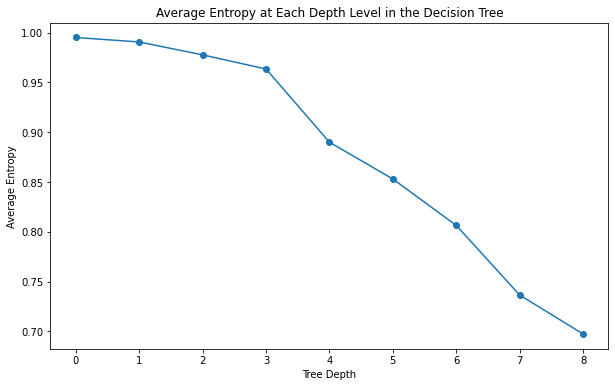

In [32]:
from collections import defaultdict

# Initialize dictionary to store entropy values for each depth level
depth_entropy = defaultdict(list)

# Recursive function to calculate depth and gather entropy values
def get_depth_entropy(node_id, current_depth):
    # Record entropy for the current depth
    entropy = tree_model.tree_.impurity[node_id]
    depth_entropy[current_depth].append(entropy)
    
    # If the node is not a leaf, call the function recursively for child nodes
    if tree_model.tree_.children_left[node_id] != -1:  # left child exists
        get_depth_entropy(tree_model.tree_.children_left[node_id], current_depth + 1)
    if tree_model.tree_.children_right[node_id] != -1:  # right child exists
        get_depth_entropy(tree_model.tree_.children_right[node_id], current_depth + 1)

# Start from the root node (node 0) at depth 0
get_depth_entropy(0, 0)

# Calculate average entropy at each depth level
depths = sorted(depth_entropy.keys())
average_entropy = [np.mean(depth_entropy[depth]) for depth in depths]

# Plot the corrected entropy at each depth
plt.figure(figsize=(10, 6))
plt.plot(depths, average_entropy, marker='o', linestyle='-')
plt.xlabel("Tree Depth")
plt.ylabel("Average Entropy")
plt.title("Average Entropy at Each Depth Level in the Decision Tree")
plt.show()


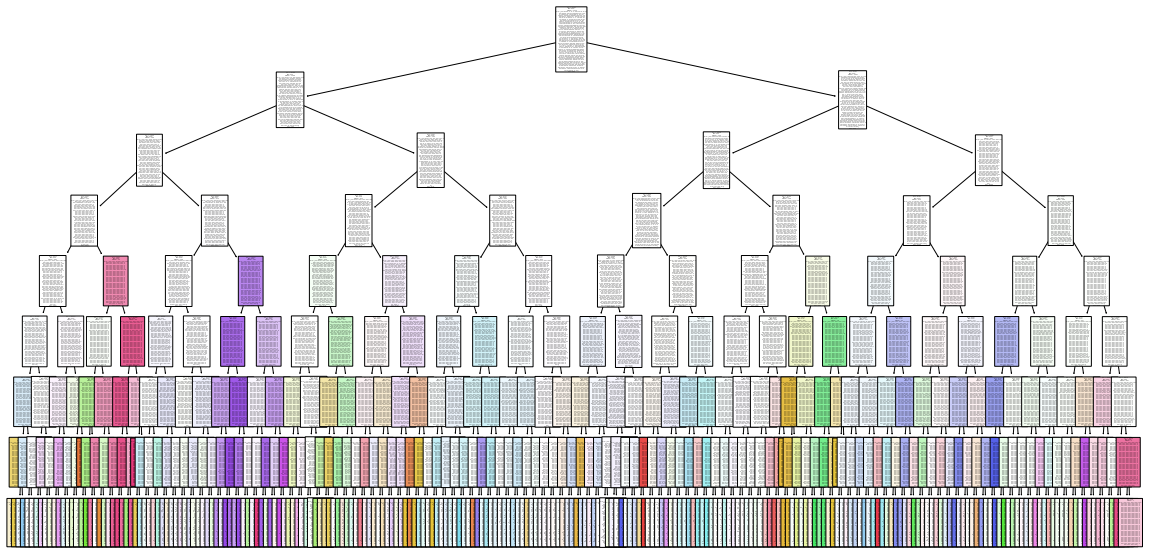

In [33]:
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

# Plot the decision tree
plt.figure(figsize=(20, 10))  # Adjust size as needed
plot_tree(tree_model, feature_names=['lat', 'long'], class_names=target_names, filled=True, rounded=True)
plt.show()

In [34]:
from sklearn.tree import _tree

# Function to print the decision path for each leaf node up to a specified depth
def print_decision_paths(tree, feature_names):
    tree_ = tree.tree_
    paths = []  # Store paths for each leaf node

    def recurse(node, depth, path):
        # Check if we've reached a leaf node or max depth
        if tree_.feature[node] != _tree.TREE_UNDEFINED:  # Non-leaf node
            # Get the feature and threshold for the split
            feature = feature_names[tree_.feature[node]]
            threshold = tree_.threshold[node]
            # Go to the left child
            left_path = path + [f"{feature} <= {threshold:.2f}"]
            recurse(tree_.children_left[node], depth + 1, left_path)
            # Go to the right child
            right_path = path + [f"{feature} > {threshold:.2f}"]
            recurse(tree_.children_right[node], depth + 1, right_path)
        else:
            # Leaf node: store the path leading to this leaf
            paths.append(path)

    # Start recursion from the root node
    recurse(0, 0, [])

    # Print all paths
    for i, path in enumerate(paths):
        print(f"Leaf {i + 1}:")
        print(" -> ".join(path))
        print()

# Specify the feature names and call the function
feature_names = ['latitude', 'longitude']
print_decision_paths(tree_model, feature_names)


Leaf 1:
longitude <= -26.46 -> longitude <= -98.75 -> longitude <= -114.25 -> latitude <= 59.66 -> latitude <= 38.61 -> longitude <= -121.98 -> longitude <= -146.01 -> latitude <= 19.49

Leaf 2:
longitude <= -26.46 -> longitude <= -98.75 -> longitude <= -114.25 -> latitude <= 59.66 -> latitude <= 38.61 -> longitude <= -121.98 -> longitude <= -146.01 -> latitude > 19.49

Leaf 3:
longitude <= -26.46 -> longitude <= -98.75 -> longitude <= -114.25 -> latitude <= 59.66 -> latitude <= 38.61 -> longitude <= -121.98 -> longitude > -146.01 -> latitude <= 38.20

Leaf 4:
longitude <= -26.46 -> longitude <= -98.75 -> longitude <= -114.25 -> latitude <= 59.66 -> latitude <= 38.61 -> longitude <= -121.98 -> longitude > -146.01 -> latitude > 38.20

Leaf 5:
longitude <= -26.46 -> longitude <= -98.75 -> longitude <= -114.25 -> latitude <= 59.66 -> latitude <= 38.61 -> longitude > -121.98 -> longitude <= -116.41 -> latitude <= 34.55

Leaf 6:
longitude <= -26.46 -> longitude <= -98.75 -> longitude <= -11

## Annie visualization

In [18]:
#pip install cartopy

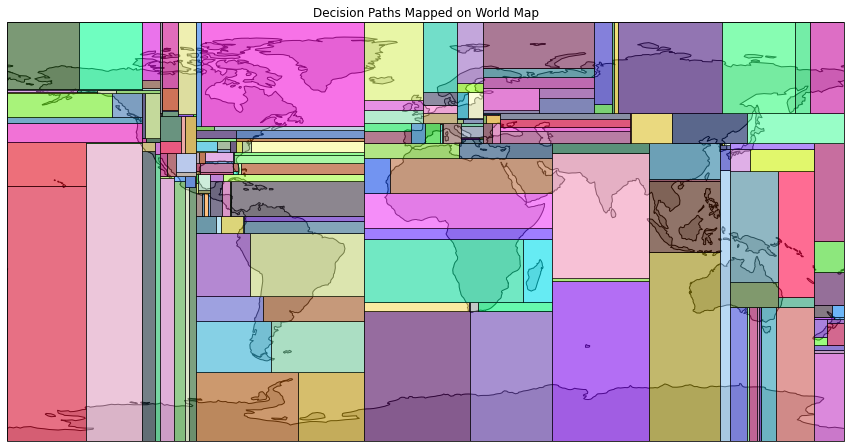

In [35]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from shapely.geometry import Polygon
import random
from sklearn.tree import _tree

# Function to plot decision paths on a world map using Cartopy
def plot_decision_paths_on_map(tree, feature_names):
    tree_ = tree.tree_
    paths = []  # Store paths for each leaf node
    
    # Create a Cartopy map
    fig, ax = plt.subplots(1, 1, figsize=(15, 10), subplot_kw={'projection': ccrs.PlateCarree()})
    ax.add_feature(cfeature.LAND, color="lightgrey")  # Base layer for land
    ax.add_feature(cfeature.COASTLINE)
    ax.set_global()  # Set map to show the entire world

    def recurse(node, depth, path, bounds):
        if tree_.feature[node] != _tree.TREE_UNDEFINED:  # Non-leaf node
            # Get the feature and threshold for the split
            feature = feature_names[tree_.feature[node]]
            threshold = tree_.threshold[node]
            
            if feature == 'latitude':
                left_bounds = bounds.copy()
                left_bounds['lat_max'] = min(left_bounds['lat_max'], threshold)
                right_bounds = bounds.copy()
                right_bounds['lat_min'] = max(right_bounds['lat_min'], threshold)
            elif feature == 'longitude':
                left_bounds = bounds.copy()
                left_bounds['lon_max'] = min(left_bounds['lon_max'], threshold)
                right_bounds = bounds.copy()
                right_bounds['lon_min'] = max(right_bounds['lon_min'], threshold)
            
            # Recurse left and right
            recurse(tree_.children_left[node], depth + 1, path + [f"{feature} <= {threshold:.2f}"], left_bounds)
            recurse(tree_.children_right[node], depth + 1, path + [f"{feature} > {threshold:.2f}"], right_bounds)
        else:
            # Leaf node: store the path and corresponding bounds
            paths.append((path, bounds))
            
            # Define and plot the polygon for this leaf node
            polygon = Polygon([
                (bounds['lon_min'], bounds['lat_min']),
                (bounds['lon_min'], bounds['lat_max']),
                (bounds['lon_max'], bounds['lat_max']),
                (bounds['lon_max'], bounds['lat_min'])
            ])
            color = (random.random(), random.random(), random.random())  # Random color
            ax.add_geometries([polygon], crs=ccrs.PlateCarree(), facecolor=color, edgecolor="black", alpha=0.6)

    # Initial bounds for the entire world map (adjust if needed)
    initial_bounds = {
        'lat_min': -90, 'lat_max': 90,
        'lon_min': -180, 'lon_max': 180
    }

    # Start recursion from the root node
    recurse(0, 0, [], initial_bounds)
    
    plt.title("Decision Paths Mapped on World Map")
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.show()

# Specify the feature names and call the function
feature_names = ['latitude', 'longitude']
plot_decision_paths_on_map(tree_model, feature_names)


In [40]:
## Annie saving these georgraphical regions as a dataframe

# Function to generate a DataFrame with leaf node information
def create_leaf_dataframe(tree, feature_names):
    tree_ = tree.tree_
    leaf_data = []  # List to collect data for each leaf

    def recurse(node, depth, path, bounds):
        if tree_.feature[node] != _tree.TREE_UNDEFINED:  # Non-leaf node
            # Get the feature and threshold for the split
            feature = feature_names[tree_.feature[node]]
            threshold = tree_.threshold[node]
            
            # Adjust bounds for the left and right splits
            if feature == 'latitude':
                left_bounds = bounds.copy()
                left_bounds['lat_max'] = min(left_bounds['lat_max'], threshold)
                right_bounds = bounds.copy()
                right_bounds['lat_min'] = max(right_bounds['lat_min'], threshold)
            elif feature == 'longitude':
                left_bounds = bounds.copy()
                left_bounds['lon_max'] = min(left_bounds['lon_max'], threshold)
                right_bounds = bounds.copy()
                right_bounds['lon_min'] = max(right_bounds['lon_min'], threshold)
            
            # Recurse for left and right children
            recurse(tree_.children_left[node], depth + 1, path + [f"{feature} <= {threshold:.2f}"], left_bounds)
            recurse(tree_.children_right[node], depth + 1, path + [f"{feature} > {threshold:.2f}"], right_bounds)
        else:
            # Leaf node: Collect data for the DataFrame
            leaf_data.append({
                "Leaf Number": len(leaf_data) + 1,
                "Latitude Range": (bounds['lat_min'], bounds['lat_max']),
                "Longitude Range": (bounds['lon_min'], bounds['lon_max'])
            })

    # Initial bounds for the entire world map (adjust if needed)
    initial_bounds = {
        'lat_min': -90, 'lat_max': 90,
        'lon_min': -180, 'lon_max': 180
    }

    # Start recursion from the root node
    recurse(0, 0, [], initial_bounds)
    
    # Convert the collected data into a DataFrame
    df = pd.DataFrame(leaf_data)
    return df

# Specify the feature names and create the DataFrame
feature_names = ['latitude', 'longitude']
leaf_df = create_leaf_dataframe(tree_model, feature_names)

# Display the DataFrame
print(leaf_df.shape)
leaf_df.head()

leaf_df.to_csv('Data/geographical_regions.csv', index=False)


(252, 3)


# Matteo that the function that you want to use (find_leaf_for_location)

In [29]:
import numpy as np

def find_leaf_for_location(tree_model, latitude, longitude):
    # Create a sample array with the location
    sample = np.array([[latitude, longitude]])

    # Use the `apply` method to get the index of the leaf node
    leaf_index = tree_model.apply(sample)[0]

    # Optionally, retrieve information about the leaf
    tree = tree_model.tree_
    leaf_impurity = tree.impurity[leaf_index]
    leaf_samples = tree.n_node_samples[leaf_index]

    # Output information about the leaf
    print(f"Location (latitude={latitude}, longitude={longitude}) reaches leaf node {leaf_index}.")
    print(f"Leaf impurity (entropy/gini): {leaf_impurity}")
    print(f"Number of samples in this leaf: {leaf_samples}")
    
    return leaf_index

# Example usage:
latitude = -23.635391   # example latitude
longitude = -46.610573 # example longitude
find_leaf_for_location(tree_model, latitude, longitude)

Location (latitude=-23.635391, longitude=-46.610573) reaches leaf node 142.
Leaf impurity (entropy/gini): 0.970111906976418
Number of samples in this leaf: 7065


/opt/miniconda3/envs/dbba_env/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
  warnings.warn(


142

# Mean Value

In [25]:
grouped_data = data_train.groupby('id').agg({
    'lat': 'mean',  # or 'first', 'last', etc.
    'long': 'mean'})
grouped_data

,lat,long
id,,
458,-23.635391,-46.610573
460,-31.017895,-57.912819
487,-25.073004,20.192400
585,33.882202,80.526962
871,35.205753,-2.006270
...,...,...
1289606,56.475147,-75.294388
1289647,-22.456312,-49.856724
1289681,22.039534,-79.168694


In [9]:
grouped_data.loc[458]

lat    -23.635391
long   -46.610573
Name: 458, dtype: float32

In [10]:
if int('458') in grouped_data.index:
    print('hello')

hello


# Gaussian Distribution

In [11]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from scipy.stats import multivariate_normal

# Example data
data = data_train.copy()

# Fit a bivariate Gaussian for each species
species_distributions = {}

# Group by species and fit Gaussian distribution to each group's latitude and longitude
for species, group in data.groupby('id'):
    # Calculate mean of latitude and longitude
    mean = [group['lat'].mean(), group['long'].mean()]
    
    # Calculate covariance matrix for latitude and longitude
    covariance = np.cov(group['lat'], group['long'])
    
    # Store the mean and covariance in a dictionary for each species
    species_distributions[species] = {
        'mean': mean,
        'covariance': covariance
    }

# Function to predict location for a given species by sampling from the bivariate normal distribution
def predict_location(species_name):
    if species_name in species_distributions:
        mean = species_distributions[species_name]['mean']
        covariance = species_distributions[species_name]['covariance']
        
        # Sample a new (latitude, longitude) from the bivariate Gaussian distribution
        location = multivariate_normal.rvs(mean=mean, cov=covariance)
        return location[0], location[1]  # Return latitude, longitude
    else:
        return None  # Species not found

# Example prediction
predicted_lat, predicted_lon = predict_location(458)
print(f'Predicted Location for species1: Latitude: {predicted_lat}, Longitude: {predicted_lon}')


Predicted Location for species1: Latitude: -28.13183434726232, Longitude: -52.489895386070835


# K-Nearest Neighbors

In [12]:
data_train1 = data_train[:10000]


In [13]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_squared_error


# Assuming 'df' is your DataFrame with 'species_id', 'plan', and 'lot'
# Step 1: Create dummy variables for species_id
dummies = pd.get_dummies(data_train1['id'], prefix='species')
df_with_dummies = pd.concat([data_train1.drop('id', axis=1), dummies], axis=1)

# Step 2: Prepare features and target
X = df_with_dummies.drop(columns=['lat', 'long'])  # Features (dummy variables)
y = df_with_dummies[['lat', 'long']]                # Target (plan and lot)


# Step 5: Set up KNN Regressor with MultiOutputRegressor for multiple targets
knn = KNeighborsRegressor()
multi_output_knn = MultiOutputRegressor(knn)

# Step 6: Use GridSearchCV to optimize the number of neighbors 'k'
param_grid = {'estimator__n_neighbors': list(range(1, 30))}  # Testing k from 1 to 30
grid_search = GridSearchCV(multi_output_knn, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X, y)

# Get the best model
best_knn = grid_search.best_estimator_
best_k = grid_search.best_params_['estimator__n_neighbors']
print(f"Optimal number of neighbors: {best_k}")


KeyboardInterrupt: 

In [35]:
dummies_test = pd.get_dummies(test_ids[:100], prefix='species')
y_pred = best_knn.predict(dummies_test)

ValueError: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- species_10090
- species_1078
- species_117054
- species_12716
- species_12735
- ...
